In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import scipy as sci
from requests import get
import folium
from geopy.geocoders import ArcGIS
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 10) 

In [2]:
url = 'http://feed.unmung.com/feed?feed=http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5+_month.atom'

In [3]:
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')

In [4]:
Location=soup.find_all('a',class_="u-url")
Data=soup.find_all('span',class_="e-summary")
#g1=Data[0].find_all('dd')
#g2=Data[1].find_all('dd')
#L=Location[1].get_text()

Location.pop(0)
def mag_title(x):
    magnitude=float(x[1:5])
    location=x[7:]
    return(magnitude,location)

Locate=[]
magni=[]
for kip in Location:
    inter=kip.get_text()
    poper=mag_title(inter)
    Locate.append(poper[1])
    magni.append(poper[0])


In [5]:
time=[]
loc=[]
depth=[]
for stuff in Data:
    j=stuff.find_all('dd')
    time.append(j[0].get_text())
    loc.append(j[2].get_text())
    depth.append(j[3].get_text())   

In [6]:
def lattitudel(x):
    if "S" in x:
        cord=-float(x.replace('°S',''))
    else:
        cord=float(x.replace('°N',''))
    return(cord)

def longitudel(x):
    if "W" in x:
        cord=-float(x.replace('°W',''))
    else:
        cord=float(x.replace('°E',''))
    return(cord)
def coord_split(x):
    half=len(x)//2
    first=x[:half]
    last=x[half:]
    return(first,last)

lattitude=[]
longitude=[]
for sets in loc:
    x,y=coord_split(sets)
    lattitude.append(lattitudel(x))
    longitude.append(longitudel(y))


In [7]:
def cool(m):
    if 0<=m<1:
        return('green')
    elif 1<=m<2:
        return('orange')
    elif 2<=m<3:
        return('blue')
    elif 3<=m<4:
        return('teal')
    elif 5<=m<6:
        return('purple')
    elif 6<=m<7:
        return('amber')
    else:
        return('red')
    
nom=ArcGIS()
p=nom.geocode("1518 Iron Gray Drive, Riverton, UT 84065")
map=folium.Map(location=[p.latitude,p.longitude], zoom_start=4, tiles="Stamen Terrain")

html="""<h4><b>Earquakes Info</b></h4>
<b>country: </b>%s
<br>
<b>Magnitude: </b>%s
<br>"""
fgv=folium.FeatureGroup(name="shake")
for la, lo, m,l in zip(lattitude,longitude,magni,Locate):
    iframe=folium.IFrame(html=html %(l,str(m)),width=200,height=100)
    fgv.add_child(folium.CircleMarker(location=[la,lo],fill_color=cool(m),popup=folium.Popup(iframe),fill=True,color='black',fill_capacity=0.9))
map.add_child(fgv)

In [8]:
from scipy.cluster import hierarchy 
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA 

In [9]:
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

#Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

#Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

Database=pd.concat([data_2019,data_2020])
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('+',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('-',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('JMA',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('Shindo ','')

def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
Database['Intensity (MMI / JMA)']=[change(chest) for chest in Database['Intensity (MMI / JMA)']]
Database

Date (UTC)   Country     Region  Magnitude  Intensity (MMI / JMA)    Lat  \
0    1/1/2019     Italy    Abruzzo        4.1                    5.0  41.88   
1    1/3/2019    Mexico   Veracruz        4.2                    NaN  19.41   
2    1/3/2019     China    Sichuan        5.3                    7.0  28.20   
3    1/3/2019     Japan   Kumamoto        5.0                    6.0  32.97   
4    1/4/2019   Albania      Vlore        4.8                    NaN  40.05   
..        ...       ...        ...        ...                    ...    ...   
75  3/13/2020     India     Kerala        2.8                    NaN   9.79   
76  3/13/2020  Tanzania      Tanga        4.8                    NaN  -4.90   
77  3/14/2020      Iran        Qom        4.0                    NaN  34.56   
78  3/15/2020      Iran  Hormozgan        5.4                    NaN  27.20   
79  3/16/2020     India  Rajasthan        3.1                    NaN  26.90   

      Long  Fatalities  Injuries  displaced  Impact value (D)  \
0    13.55         0.0       0.0        0.0          0.027151   
1   -97.05         0.0       0.0        0.0          0.030895   
2   104.86         0.0       1.0      251.0          1.150904   
3   130.47         0.0       3.0        0.0          0.261225   
4    19.88         0.0       0.0        0.0          0.019565   
..     ...         ...       ...        ...               ...   
75   76.88         0.0       0.0        0.0          0.038254   
76   38.55         0.0       0.0        0.0          0.007925   
77   50.72         0.0       0.0        0.0          0.038254   
78   55.32         0.0       2.0        0.0          0.235972   
79   75.30         0.0       0.0        0.0          0.007925   

    buildings damaged  buildings destroyed  
0                 7.0                  0.0  
1                 8.0                  0.0  
2               753.0                 44.0  
3                 7.0                  0.0  
4                 5.0                  0.0  
..                ...                  ...  
75               10.0                  0.0  
76                2.0                  0.0  
77               10.0                  0.0  
78               20.0                  1.0  
79                2.0                  0.0  

[405 rows x 13 columns]

In [10]:
Current=pd.DataFrame(zip(time,Locate,magni,depth,lattitude,longitude), columns=['time','Location','Magnitude','Depth (km)','lattitude','longitude'])


Text(0.5, 1.0, 'Principal Component of States')

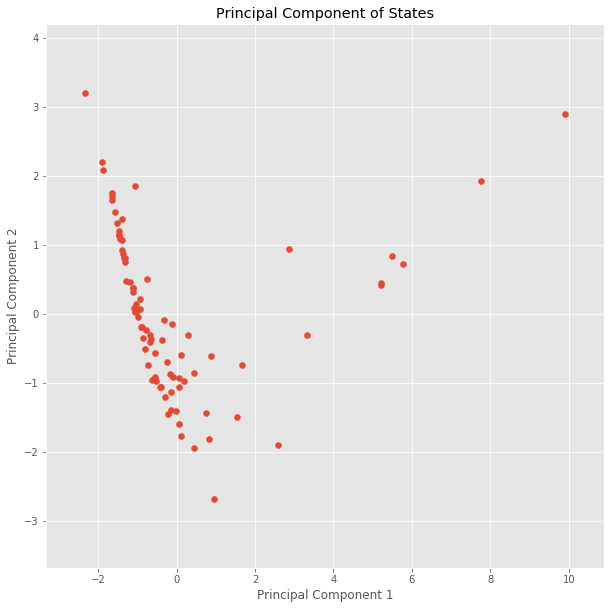

In [11]:
dat=Database[['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']].dropna()
sca=scale(dat)
pca_model = PCA()
X_PCA = pca_model.fit_transform(sca)
fig, ax = plt.subplots()
ax.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)
plt.scatter(X_PCA[:,0],X_PCA[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component of States')

In [12]:
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

[0.57296607 0.17127359 0.10469433 0.06114026 0.04497316 0.02407714
 0.0156102  0.00526525]


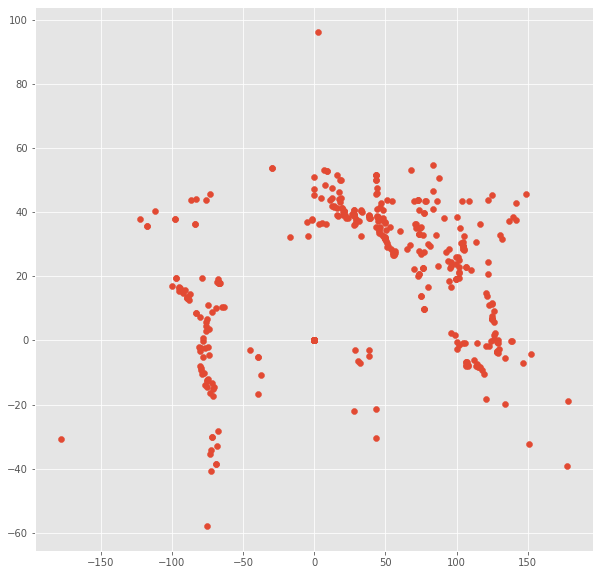

In [13]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#e41a1c","#984ea3","#a65628","#377eb8"])
plt.scatter(Database['Long'],Database['Lat'])

C:\Users\paulm\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


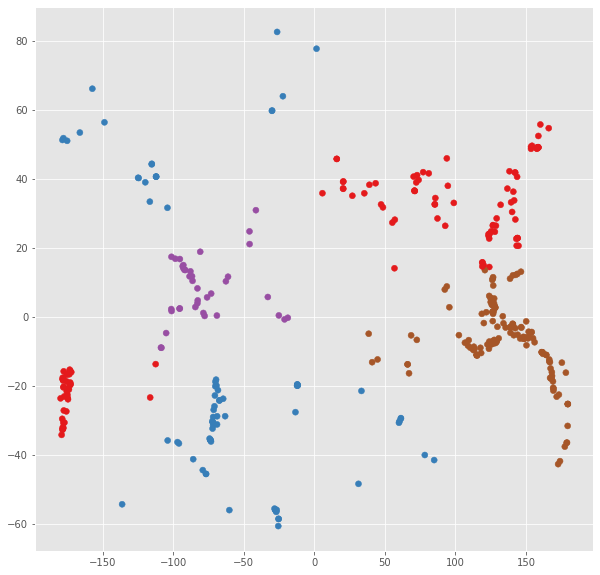

In [14]:
quac=Current[['lattitude','longitude']]
scal=scale(quac)
y_pred = KMeans(n_clusters=6,n_init=50).fit_predict(scal)
quac['grouping']=y_pred
Current['grouping']=y_pred
plt.scatter(quac['longitude'],quac['lattitude'],c=y_pred,cmap=cmap)

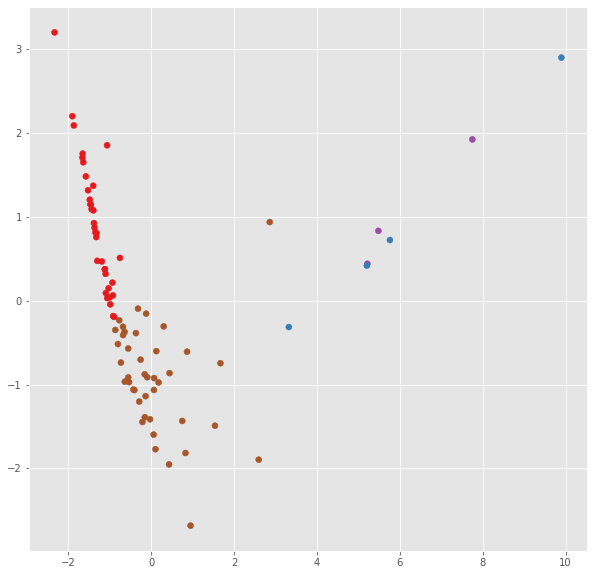

In [118]:
y_pred = KMeans(n_clusters=4).fit_predict(sca)
dat['grouping']=y_pred
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred,cmap=cmap)

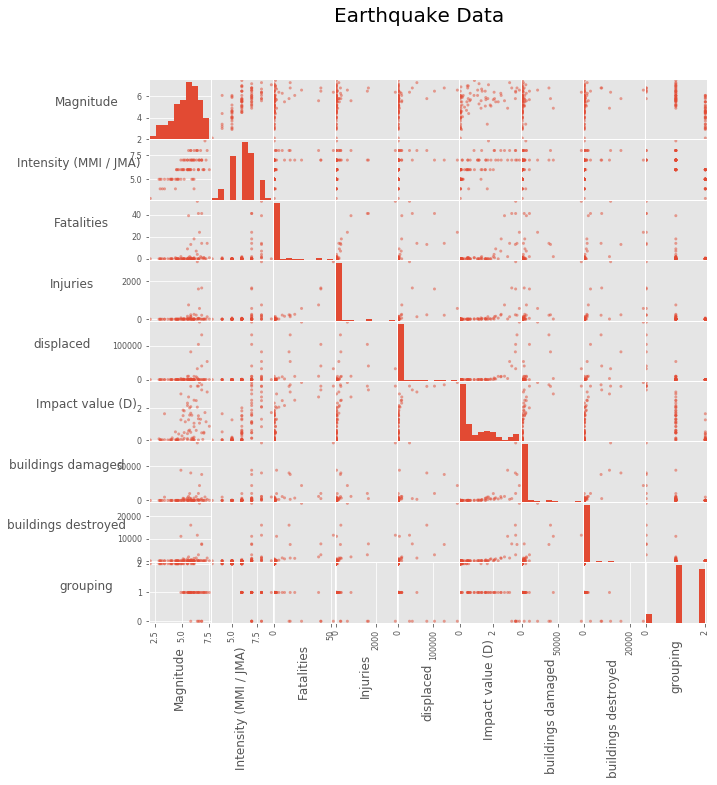

In [97]:
axs=pd.plotting.scatter_matrix(dat)
plt.suptitle('Earthquake Data', size=20)
n = len(dat.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

In [112]:
from sklearn.metrics import silhouette_score

for n in range(2,21):
    clusters = KMeans(n_clusters=n, random_state=1).fit_predict(sca)
    sil = silhouette_score(sca, clusters)
    print('n = %d. Score =%f '%(n,round(sil, 5)))


n = 2. Score =0.667430 
n = 3. Score =0.355860 
n = 4. Score =0.376630 
n = 5. Score =0.381900 
n = 6. Score =0.329150 
n = 7. Score =0.325600 
n = 8. Score =0.291460 
n = 9. Score =0.291320 
n = 10. Score =0.269220 
n = 11. Score =0.307280 
n = 12. Score =0.270560 
n = 13. Score =0.272980 
n = 14. Score =0.278410 
n = 15. Score =0.272480 
n = 16. Score =0.284870 
n = 17. Score =0.298490 
n = 18. Score =0.308670 
n = 19. Score =0.304560 
n = 20. Score =0.314450 


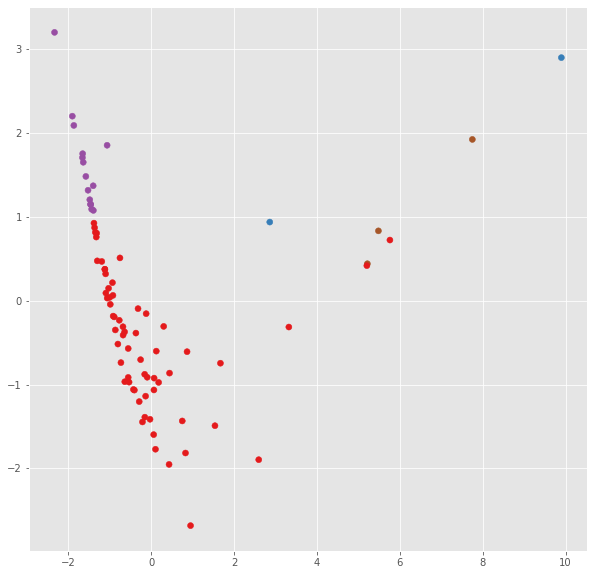

In [115]:
agg_cluster_model = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=7)
y_pred1 = agg_cluster_model.fit_predict(sca)
dat['grouping1']=y_pred1
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred1,cmap=cmap)

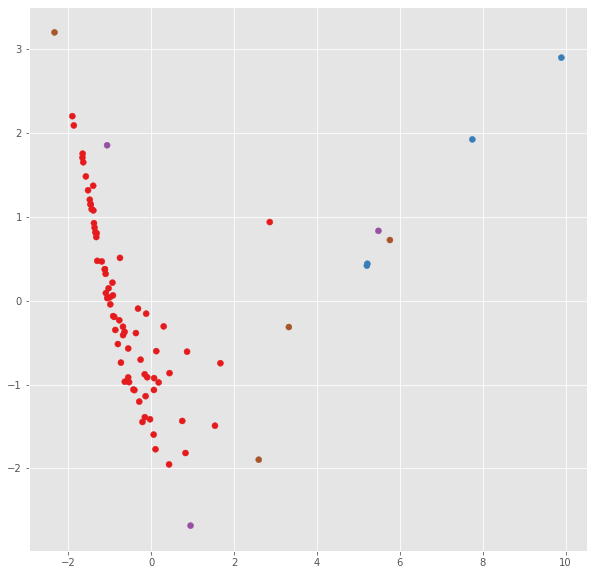

In [117]:
db_model = DBSCAN(eps=1, min_samples=1).fit(sca)
y_pred2 = db_model.fit_predict(sca)
dat['grouping2']=y_pred2
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred2,cmap=cmap)

In [15]:
Current

time                                     Location  \
0    2020-04-10 14:46:09 UTC        86km SSW of Ile Hunter, New Caledonia   
1    2020-04-10 10:22:57 UTC                    42km S of Shizunai, Japan   
2    2020-04-10 06:46:16 UTC       122km SW of Lorengau, Papua New Guinea   
3    2020-04-10 04:40:18 UTC             110km SW of Merizo Village, Guam   
4    2020-04-10 03:46:21 UTC      130km SSW of Lorengau, Papua New Guinea   
..                       ...                                          ...   
378  2020-03-12 03:57:59 UTC           24km WSW of Palimbang, Philippines   
379  2020-03-11 21:30:04 UTC                                Greenland Sea   
380  2020-03-11 19:54:08 UTC                    133km SE of Neiafu, Tonga   
381  2020-03-11 17:18:04 UTC   153km SSE of L'Esperance Rock, New Zealand   
382  2020-03-11 17:04:25 UTC                  96km WSW of Coquimbo, Chile   

     Magnitude           Depth (km)  lattitude  longitude  grouping  
0          4.6  47.82 km (29.71 mi)    -23.145    171.807         3  
1          4.5  59.85 km (37.19 mi)     41.954    142.285         0  
2          4.5   10.00 km (6.21 mi)     -2.938    146.649         3  
3          5.0   10.00 km (6.21 mi)     12.520    143.997         3  
4          4.9   10.00 km (6.21 mi)     -3.105    146.802         3  
..         ...                  ...        ...        ...       ...  
378        4.6   10.00 km (6.21 mi)      6.113    123.994         3  
379        4.6   10.00 km (6.21 mi)     77.903      1.612         5  
380        5.2   10.00 km (6.21 mi)    -19.334   -172.942         1  
381        4.5   10.00 km (6.21 mi)    -32.764   -178.434         1  
382        4.6    5.46 km (3.39 mi)    -30.296    -72.263         4  

[383 rows x 7 columns]

In [17]:
import re
import pycountry
def co(text):
    for country in pycountry.countries:
        if country.name in text:
            return(country.name)
t=[]
for i,text in enumerate(Current['Location']):
    j=re.findall(r",([\w\s]+)",text)
    if len(j)==0:
        if type(co(text)) is None:
            t.append(co(text))
        else:
            t.append(text)
    elif len(j)>0:
        t.extend(j)
    else:
        t.append(text)
Current['Country']=t
Current

time                                     Location  \
0    2020-04-10 14:46:09 UTC        86km SSW of Ile Hunter, New Caledonia   
1    2020-04-10 10:22:57 UTC                    42km S of Shizunai, Japan   
2    2020-04-10 06:46:16 UTC       122km SW of Lorengau, Papua New Guinea   
3    2020-04-10 04:40:18 UTC             110km SW of Merizo Village, Guam   
4    2020-04-10 03:46:21 UTC      130km SSW of Lorengau, Papua New Guinea   
..                       ...                                          ...   
378  2020-03-12 03:57:59 UTC           24km WSW of Palimbang, Philippines   
379  2020-03-11 21:30:04 UTC                                Greenland Sea   
380  2020-03-11 19:54:08 UTC                    133km SE of Neiafu, Tonga   
381  2020-03-11 17:18:04 UTC   153km SSE of L'Esperance Rock, New Zealand   
382  2020-03-11 17:04:25 UTC                  96km WSW of Coquimbo, Chile   

     Magnitude           Depth (km)  lattitude  longitude  grouping  \
0          4.6  47.82 km (29.71 mi)    -23.145    171.807         3   
1          4.5  59.85 km (37.19 mi)     41.954    142.285         0   
2          4.5   10.00 km (6.21 mi)     -2.938    146.649         3   
3          5.0   10.00 km (6.21 mi)     12.520    143.997         3   
4          4.9   10.00 km (6.21 mi)     -3.105    146.802         3   
..         ...                  ...        ...        ...       ...   
378        4.6   10.00 km (6.21 mi)      6.113    123.994         3   
379        4.6   10.00 km (6.21 mi)     77.903      1.612         5   
380        5.2   10.00 km (6.21 mi)    -19.334   -172.942         1   
381        4.5   10.00 km (6.21 mi)    -32.764   -178.434         1   
382        4.6    5.46 km (3.39 mi)    -30.296    -72.263         4   

               Country  
0        New Caledonia  
1                Japan  
2     Papua New Guinea  
3                 Guam  
4     Papua New Guinea  
..                 ...  
378        Philippines  
379      Greenland Sea  
380              Tonga  
381        New Zealand  
382              Chile  

[383 rows x 8 columns]

In [22]:
Help=Current[['grouping','Country']]
T=Help.groupby(['Country']).mean()
Information=Information.join(T.set_index('Country'), on='Country')
Information

NameError: name 'Information' is not defined